In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

In [3]:
model = load_model(
    "model/resnet50_unet_final.keras",
    compile=False  
)

In [4]:
def preprocess_image(image_path, target_size=(256, 256)):
    # Baca dan decode gambar
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_png(img_raw, channels=3)

    # Resize dan normalisasi
    img_resized = tf.image.resize(img, target_size)
    img_normalized = tf.cast(img_resized, tf.float32) / 255.0
    img_input = tf.expand_dims(img_normalized, axis=0)  # (1, H, W, 3)

    return img_resized.numpy().astype("uint8"), img_input

In [5]:
# --- Inference & Visualization ---
def inference_and_visualize(model, image_path, mask_path=None, class_names=None):
    img, img_input = preprocess_image(image_path, (256, 256))
    pred_mask = model.predict(img_input)[0]  # (H, W, C)
    pred_mask_argmax = np.argmax(pred_mask, axis=-1)

    plt.figure(figsize=(18, 6))

    # 1. Image + Mask (jika mask tersedia)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    if mask_path:
        mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")
        mask_array = img_to_array(mask).squeeze().astype(int)
        plt.imshow(mask_array, alpha=0.5, cmap='tab20', vmin=0, vmax=(len(class_names)-1 if class_names else 4))
        plt.title("True Image + mask")
    else:
        plt.title("Image")
    plt.axis("off")

    # 2. Prediction (mask prediksi)
    plt.subplot(1, 3, 2)
    if class_names is None:
        class_names = [f"Class {i}" for i in range(pred_mask.shape[-1])]
    cmap = plt.get_cmap('tab20', len(class_names))
    im = plt.imshow(pred_mask_argmax, cmap=cmap, vmin=0, vmax=len(class_names)-1)
    plt.title("Predicted Mask")
    plt.axis("off")
    cbar = plt.colorbar(im, ticks=range(len(class_names)), fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(class_names)
    plt.clim(-0.5, len(class_names)-0.5)

    # 3. Image + Prediction (overlay)
    plt.subplot(1, 3, 3)
    img_array = img_to_array(img) / 255.0
    mask_rgb = cmap(pred_mask_argmax)[..., :3]
    overlay = img_array.copy()
    overlay[pred_mask_argmax > 0] = (
        0.5 * img_array[pred_mask_argmax > 0] + 0.5 * mask_rgb[pred_mask_argmax > 0]
    )
    plt.imshow(overlay)
    plt.title("Image + Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [14]:
# Ganti path berikut sesuai file gambar dan mask test Anda
image_path = "datasets/dataset_split/test/images/ablation_IMG_8726.png"
mask_path = "datasets/dataset_split/test/masks/ablation_IMG_8726.png"  # opsional
class_names = ['Background', 'ablation', 'breakdown', 'fracture', 'groove']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


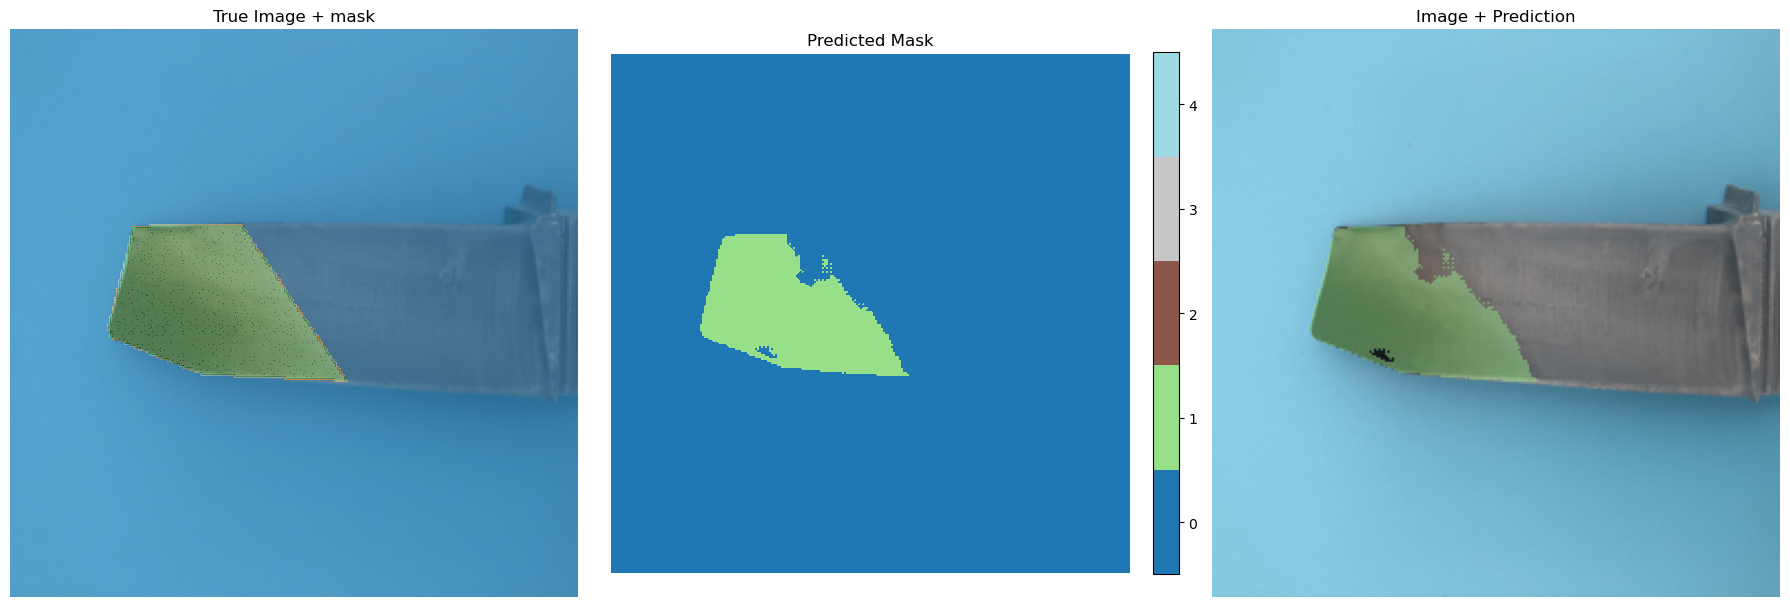

In [15]:
inference_and_visualize(model, image_path, mask_path, class_names)